Thais Lima de Sousa. October, 2016

# Hierarchical Image Segmentation based on an observation scale
## Guimarães and Najman's algorithm

In [1]:
from vpi.io import *
from vpi.filters import convolve, normalize
import numpy as np
import networkx as nx
from scipy.spatial import KDTree

In [2]:
# gaussian filter for image smoothing

def create_gauss_kernel(sigma):
    length = int(np.ceil(4*sigma)) + 1
    k = np.zeros((1, length))
    for i in range(length):
        k[0][i] = np.exp(-0.5*np.square(i/sigma))
    k = k / k.sum()

    return k

def smooth(img, sigma):
    if sigma < 0.1:
        return img
    kernel = create_gauss_kernel(sigma)  
    g = convolve(img, kernel)
    g = convolve(g, np.transpose(kernel))
    return g

In [3]:
# disjoint-set forest with union rank and path compression

class UF:
    def __init__(self, n):
        self.num = n
        self.parent = list(range(n))
        self.rank = [0 for i in range(n)]
        self.size = [1 for i in range(n)]
    
    def find(self, v):
        w = v
        while(w != self.parent[w]):
            w = self.parent[w]
        self.parent[v] = w
        return w
    
    def union(self, x, y):
        xR = self.find(x)
        yR = self.find(y)
        if xR == yR:
            return
        
        if self.rank[xR] > self.rank[yR]:
            self.parent[yR] = xR
            self.size[xR] += self.size[yR]
        
        else:
            self.parent[xR] = yR
            self.size[yR] += self.size[xR]
            if self.rank[xR] == self.rank[yR]:
                self.rank[yR] += 1
        self.num -= 1
        
    def sizec(self, x):
        x = self.find(x)
        return self.size[x]
    
    def num_sets(self):
        return self.num
    
    # for debugging 
    def print_rank(self, x):
        return self.rank[x]

In [4]:
def build_hierarchies(G):
    V = len(G)
    mst = nx.minimum_spanning_edges(G)
    mst = list(mst)
    Pw = UF(V)
    Gh = nx.Graph()
    Int = [0.0]*V
    
    for (x, y, w) in mst:
        a = Pw.find(x)
        b = Pw.find(y)
        w = w['weight']
        Sa = (w - Int[a])*Pw.sizec(a)
        Sb = (w - Int[b])*Pw.sizec(b)
        if Sa >= Sb: Gh.add_edge(x, y, weight=Sa)
        else: Gh.add_edge(x, y, weight=Sb)
        Pw.union(a, b)
        Int[Pw.find(a)] = w
        
    return Gh
        

def segment_graph(G, k):
    Pl = UF(len(G))
    H = build_hierarchies(G)
    edge_list = H.edges()
    
    for (x, y) in edge_list:
        L = H.get_edge_data(x, y)['weight']
        if L < k: Pl.union(x, y)
    
    return Pl, edge_list

In [5]:
def diff(r, g, b, x1, y1, x2, y2):
    return np.sqrt(np.square(float(r[x1, y1]) - float(r[x2, y2]))
                  + np.square(float(g[x1, y1]) - float(g[x2, y2]))
                  + np.square(float(b[x1, y1]) - float(b[x2, y2])))


# build weighted edges, 8-connected
def grid_graph(r, g, b):
    H, W = r.shape
    G = nx.Graph()
    for x in range(H):
        for y in range(W):
            if y < W - 1:
                G.add_edge(x*W + y, x*W + (y+1), weight=diff(r, g, b, x, y, x, y+1))
            if x < H - 1:
                G.add_edge(x*W + y, (x+1)*W + y, weight=diff(r, g, b, x, y, x+1, y))
            if (x < H - 1 and y < W - 1): 
                G.add_edge(x*W + y, (x+1)*W + (y + 1), weight=diff(r, g, b, x, y, x+1, y+1))
            if (y < W - 1 and x > 0): 
                G.add_edge(x*W + y, (x-1)*W + (y + 1), weight=diff(r, g, b, x, y, x-1, y+1))
    return G


""" ********* not working yet ********* """
# build weighted edges using k-nearest neighbours on the feature space
def knn_graph(r, g, b):
    H, W = r.shape
    G = nx.Graph()
    points = np.ndarray((H*W, 5))
    i = 0
    # feature point: (x, y, r, g, b)
    for x in range(H):
        for y in range(W):
            points[i, :] = [x, y, r[x, y], g[x, y], b[x, y]]
            
    tree = KDTree(points)
    for x in range(H):
        for y in range(W):
            distances, locations = tree.query([x, y, r[x, y], g[x, y], b[x, y]], r=0.3)
            for (x1, y1, x_r, x_g, x_b, w) in zip(points[locations], points[distances]):
                G.add_edge(x*W + y, x2*W + y2, weight=w)
    return G
    


def segment_image(im, sigma, k, min_size, edgew_method=1):
    r = smooth(im[:,:,0], sigma)
    g = smooth(im[:,:,1], sigma)
    b = smooth(im[:,:,2], sigma)
    

    G = nx.Graph()
    H, W = r.shape

    # build weighted edges, 8-connected
    if edgew_method == 2: G = knn_graph(r, g, b)
    else: G = grid_graph(r, g, b)
    
    
    u, edge_list2 = segment_graph(G, k)
    
    # post process small components
    for (a, b) in edge_list2:
        a = u.find(a)
        b = u.find(b)
        
        if (a != b and ((u.sizec(a) < min_size) or (u.sizec(b) < min_size))):
            u.union(a, b)
        
    num_ccs = u.num_sets()

    # pick random colors for the components
    colors = np.random.uniform(0, 255, 3*H*W).reshape(H*W, 3)
    output = np.zeros((im.shape))
    
    for x in range(H):
        for y in range(W):
            comp = u.find(x*W + y)
            for i in range(3):
                output[x, y, i] = colors[comp, i]
    
    return output, num_ccs   

In [6]:
# read input

def hierarchical_segmentation(img_name, sigma, k, min_size):
    img = read_image(img_name)
    print('Original image:')
    display_image(img)
    # save output and display segmentation
    output, num_css = segment_image(img, sigma, k, min_size)
    print('Found %d components' % num_css)
    display_image(output)

Original image:


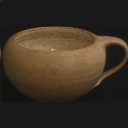

Found 20 components


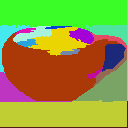

Original image:


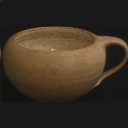

Found 13 components


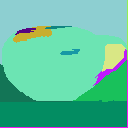

Original image:


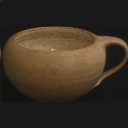

Found 4 components


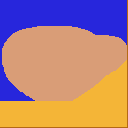

In [7]:
hierarchical_segmentation('images/img1.pnm', 0.5, 30, 50)
hierarchical_segmentation('images/img1.pnm', 0.5, 100, 50)
hierarchical_segmentation('images/img1.pnm', 0.5, 870, 50)

Original image:


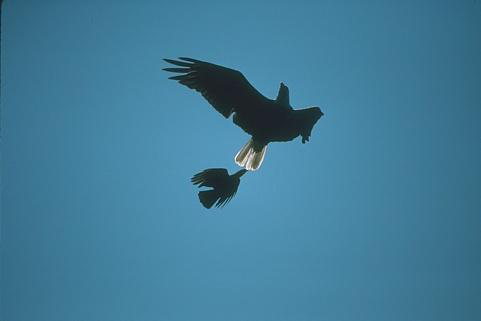

Found 5 components


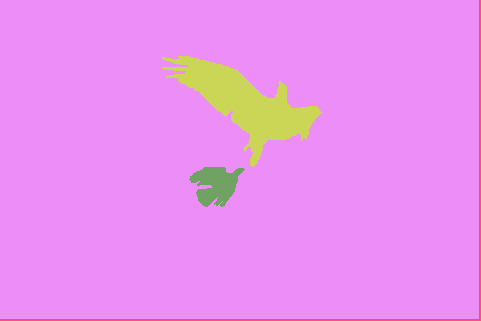

In [17]:
hierarchical_segmentation('../berkeley database/135069.jpg', 0.9, 550, 330)

Original image:


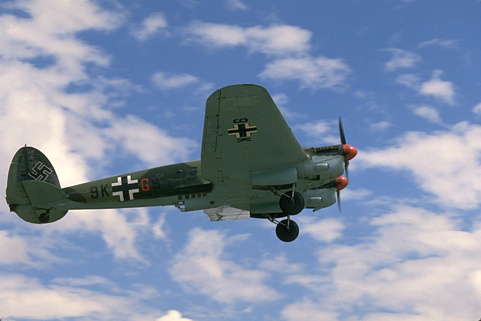

Found 6 components


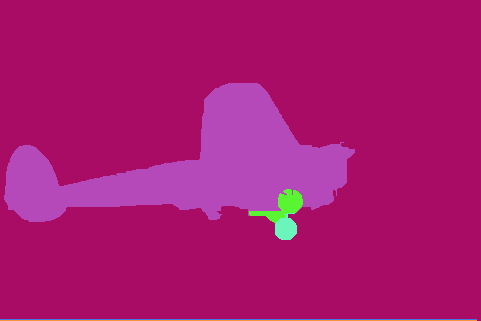

In [18]:
hierarchical_segmentation('../berkeley database/3063.jpg', 0.9, 550, 330)